# **Lane Finding Project**

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# **Camera Calibration & Distortion Correction**

for more details <a href="Camera_Calibration.ipynb">visit this notebook</a>

In [2]:
# Read in the saved camera matrix and distortion coefficients
cameraCalibrationImgs = pickle.load( open( "Camera_Calibration.p", "rb" ) )
mtx = cameraCalibrationImgs["mtx"]
dist = cameraCalibrationImgs["dist"]

In [3]:
! unzip test_images

Archive:  test_images.zip
  inflating: test_images/straight_lines1.jpg  
  inflating: test_images/straight_lines2.jpg  
  inflating: test_images/test1.jpg   
  inflating: test_images/test2.jpg   
  inflating: test_images/test3.jpg   
  inflating: test_images/test4.jpg   
  inflating: test_images/test5.jpg   
  inflating: test_images/test6.jpg   


In [4]:
# Load test images using glob.
# read test images using cv2.imread .
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob('test_images/*.jpg')))

In [5]:
# convert test images to RGB to show
Test_imgsToShow = []
for fname in testImages:
    fileName, img = fname
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    Test_imgsToShow.append(img)

In [6]:
def show_image(images,row,col):
    """
    this function use to show images
    """
    n: int = len(images)
    f = plt.figure(figsize=(15,6))
    for i in range(n):
        f.add_subplot(row,col, i + 1)
        plt.imshow(images[i])
        plt.axis("off")

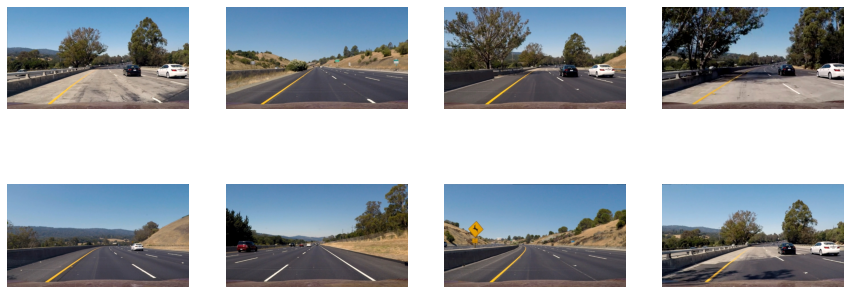

In [ ]:
# show test images
show_image(Test_imgsToShow,2,4)
# plt.savefig("Test_Images.png")

In [7]:
def cal_undistort(img, mtx, dist) :

  """
  Undistort the image with `mtx`, `dist`.

  """
  undist = cv2.undistort(img, mtx, dist, None, mtx)

  return undist

In [8]:
# apply cal_undistort function to testimages and pask the images in a list 
Undist_images = []
for fname in testImages:
    fileName, img = fname
    Undist = cal_undistort(img, mtx, dist)
    Undist_images.append(Undist)

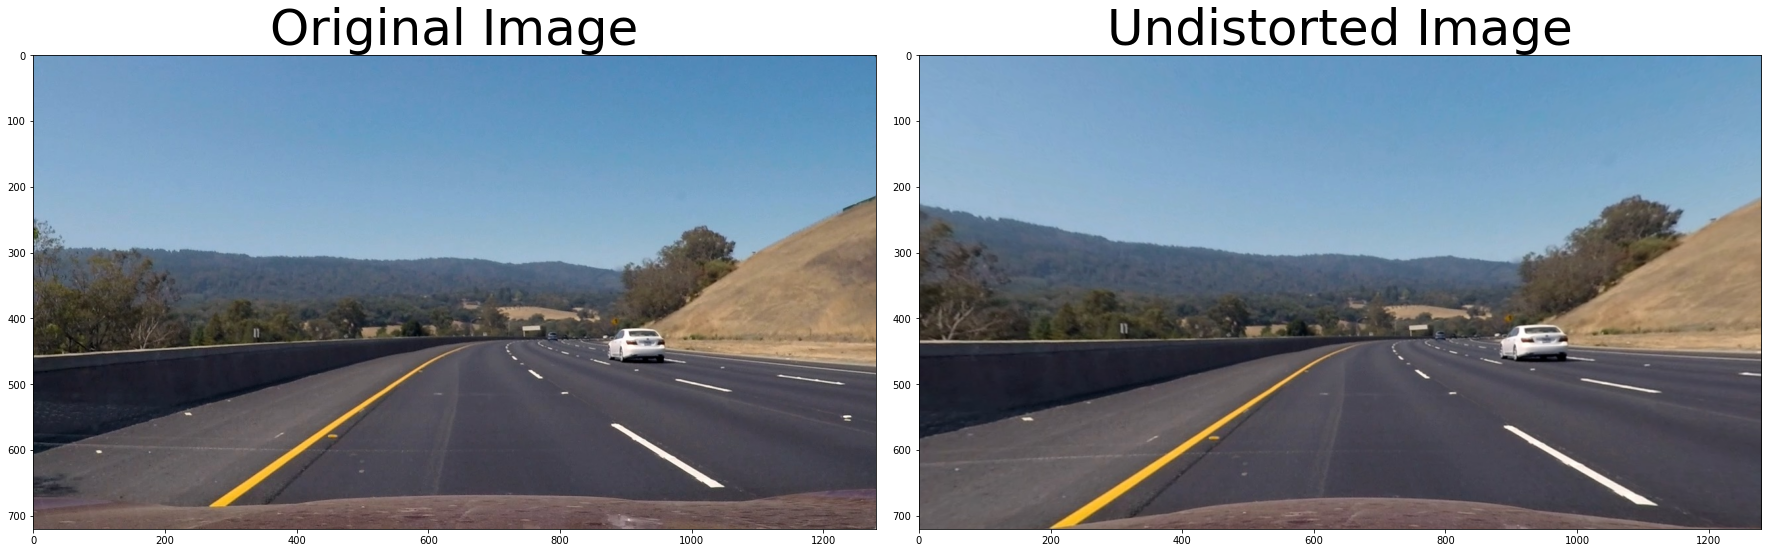

In [9]:
# example of undistor  images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(Test_imgsToShow[0])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(Undist_images[0], cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# **Gradient Threshold**

for more details <a href="Color_transform_&_Gradient_Threshold.ipynb">visit this notebook</a>

**HLS color space**


I converted images to hls using cv2.COLOR_BGR2HLS because I readed imges using cv2.imread() this will read in an BGR image

In [10]:
def hls_select(img, thresh=(0, 255)):

    '''
    This function thresholds the S-channel of HLS

    '''
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [11]:
# apply hls_select function to Undist_images and pask the images in a list to show
hls_select_imgs = []

for img in Undist_images:
  hls_img = hls_select(img, thresh=(90, 255))
  hls_select_imgs.append(hls_img)

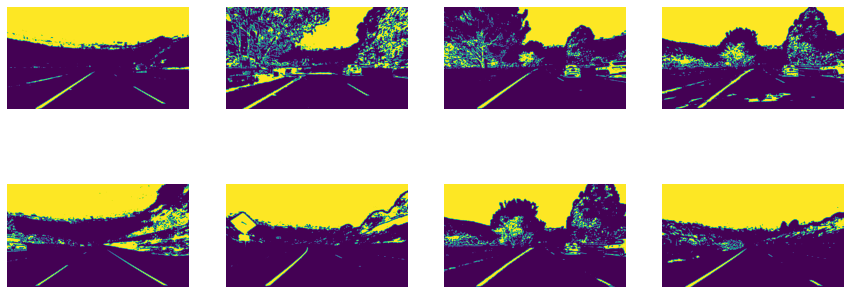

In [12]:
show_image(hls_select_imgs,2,4)
# plt.savefig("HLS-color_Images.png")

**Sobel Operator**

In [13]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):

    '''
    This function takes an image, gradient orientation, and threshold min / max values 
    returning a binary image [0, 255].

    ''' 
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [14]:
# apply abs_sobel_thresh function to Undist_images and pask the images in a list to show
grad_binaryx_imgs = []
grad_binaryy_imgs = []

for img in Undist_images:
  grad_binaryx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
  grad_binaryx_imgs.append(grad_binaryx)
  grad_binaryy = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
  grad_binaryy_imgs.append(grad_binaryy)

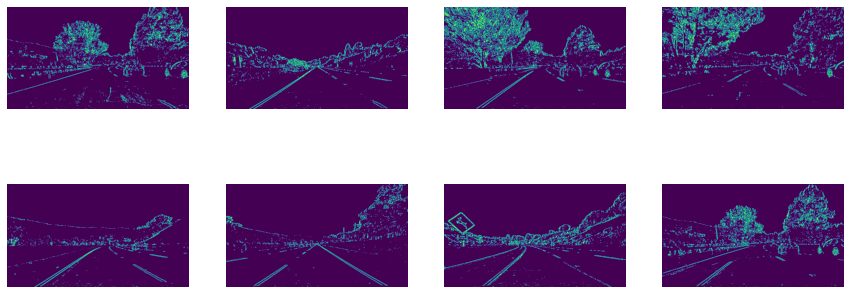

In [ ]:
#Thresholded with x-derivative
show_image(grad_binaryx_imgs,2,4)

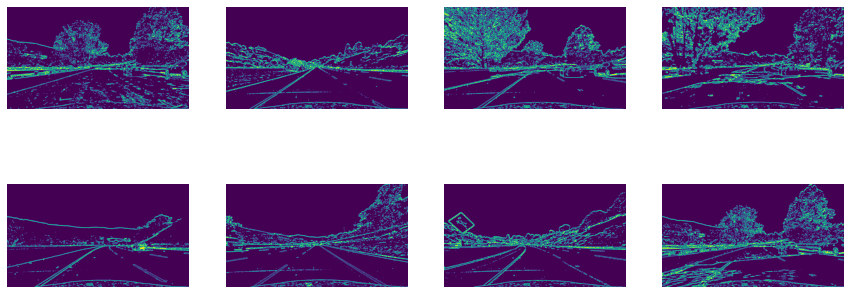

In [ ]:
#Thresholded with y-derivative
show_image(grad_binaryy_imgs,2,4)

**Gradient magnitude**

In [15]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    '''
    This function  return the magnitude of the gradient for a given sobel kernel size and threshold values

    '''
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [16]:
# apply mag_thresh function to UndistHLS_images and pask the images in a list to show
mag_binary_imgs = []

for img in Undist_images:
  mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 170))
  mag_binary_imgs.append(mag_binary)

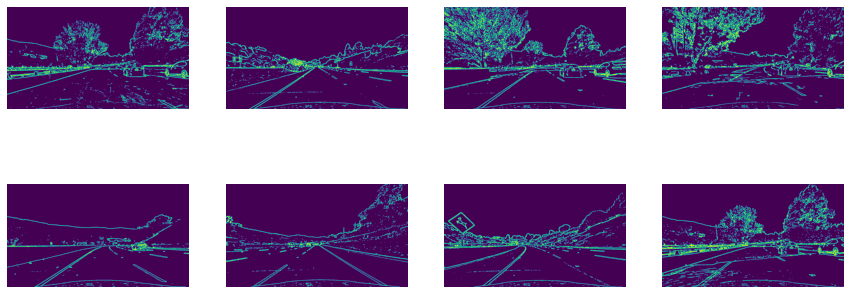

In [ ]:
show_image(mag_binary_imgs,2,4)

**Direction of the Gradient**

In [17]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    '''
    This function is  to threshold an image for a given range and Sobel kernel

    '''
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [18]:
# apply dir_threshold function to UndistHLS_images and pask the images in a list to show
dir_binary_imgs = []

for img in Undist_images:
  dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
  dir_binary_imgs.append(dir_binary)

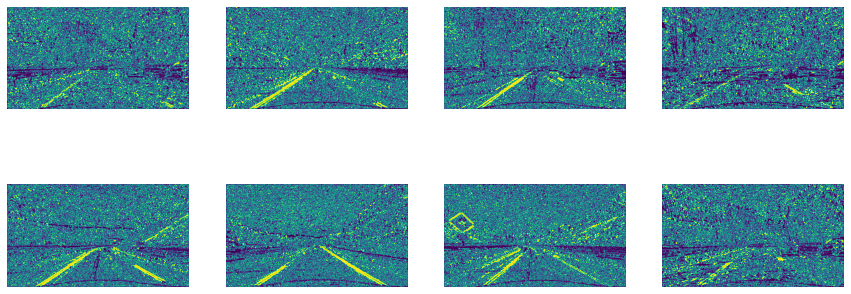

In [ ]:
show_image(dir_binary_imgs,2,4)

**Combining Thresholds**

In [19]:
def Combining_Threshold(dir_binary,grad_binaryx,grad_binaryy,mag_binary,hls_select) :
  Combining_Threshold_img = np.zeros_like(dir_binary) 
  Combining_Threshold_img[((grad_binaryx == 1) & (grad_binaryy == 1)) | ((mag_binary == 1) & (dir_binary== 1)) | (hls_select == 1)] = 1

  return Combining_Threshold_img


In [20]:
imgLength = len(Undist_images)
Combining_Thresholds_imgs = []
for index in range(0,imgLength) :
  Combining_Thresholds = Combining_Threshold(dir_binary_imgs[index],grad_binaryx_imgs[index],grad_binaryy_imgs[index],mag_binary_imgs[index],hls_select_imgs[index])
  Combining_Thresholds_imgs.append(Combining_Thresholds)

In [ ]:
'''

#create a binary image result
imgLength = len(Undist_images)
Combining_Thresholds_imgs = []
for index in range(0,imgLength) :
  Combining_Thresholds = np.zeros_like(dir_binary_imgs[index]) 
  Combining_Thresholds[((grad_binaryx_imgs[index] == 1) & (grad_binaryy_imgs[index] == 1)) | ((mag_binary_imgs[index] == 1) & (dir_binary_imgs[index] == 1)) | (hls_select_imgs[index] == 1)] = 1
  Combining_Thresholds_imgs.append(Combining_Thresholds)


'''

'\n\n#create a binary image result\nimgLength = len(Undist_images)\nCombining_Thresholds_imgs = []\nfor index in range(0,imgLength) :\n  Combining_Thresholds = np.zeros_like(dir_binary_imgs[index]) \n  Combining_Thresholds[((grad_binaryx_imgs[index] == 1) & (grad_binaryy_imgs[index] == 1)) | ((mag_binary_imgs[index] == 1) & (dir_binary_imgs[index] == 1)) | (hls_select_imgs[index] == 1)] = 1\n  Combining_Thresholds_imgs.append(Combining_Thresholds)\n\n\n'

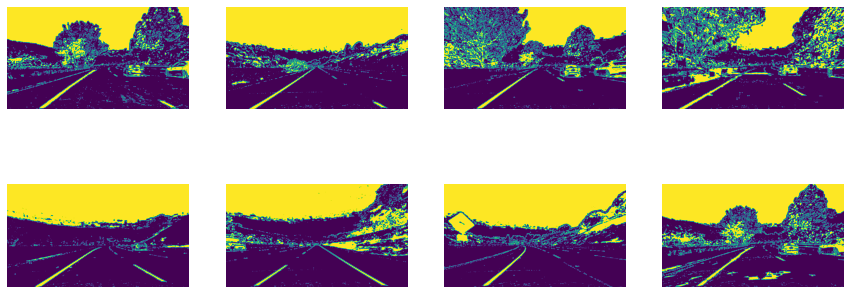

In [ ]:
show_image(Combining_Thresholds_imgs,2,4)

# **Perspective Transformation**
for more details <a href="Perspective_Transformation.ipynb">visit this notebook</a>

In [21]:
def unwarp(img):
    
    # Convert to grayscale
    # gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 

    img_size = (1280,720)

    src = np.float32(
    [[(img_size[0] / 2) - 62, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 62), img_size[1] / 2 + 100]])

    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M,img_size , flags=cv2.INTER_LINEAR)

    return warped,Minv

In [22]:
# apply abs_sobel_thresh function to UndistHLS_images and pask the images in a list to show
Warped_imgs = []

for img in Combining_Thresholds_imgs:
  Warped_img,Minv = unwarp(img)
  Warped_imgs.append(Warped_img)

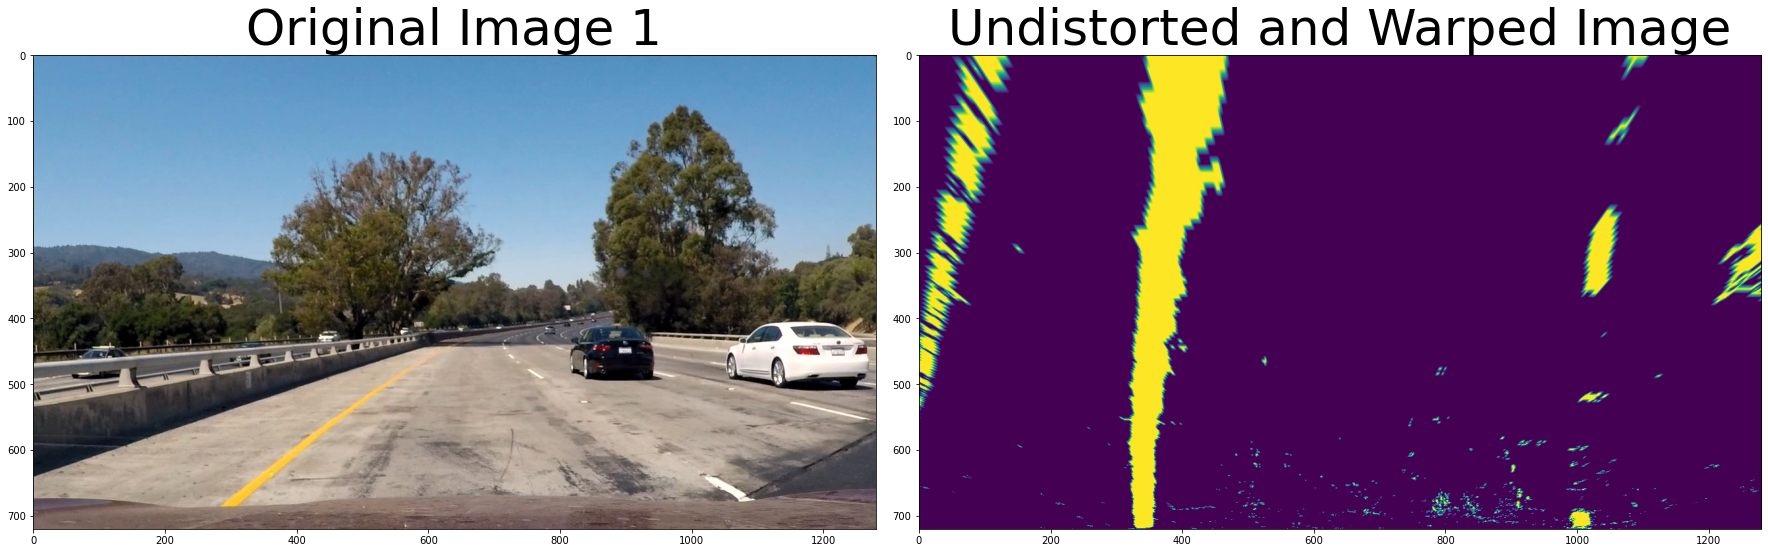

In [ ]:
# the first warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(Test_imgsToShow[0])
ax1.set_title('Original Image 1', fontsize=50)
ax2.imshow(Warped_imgs[0])
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# **Finding the Lines**

After applying threshold calibration and perspective transformation to the road image, I have now a binary image where the lane lines are clearly visible.

In [23]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [24]:
def find_firstlane(binary_warped) :
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        
        return out_img, left_fit,right_fit, left_fit_cr, right_fit_cr

In [25]:
def search_next_Lane(binary_warped,left_fit,right_fit) :
        
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # the area of search based on activated x-values 
        # within the +/- margin of our polynomial function 
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                          left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                           left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                           right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                           right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Create an image to draw on 
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
         # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        return out_img, left_fit, right_fit, left_fit_cr,right_fit_cr

In [26]:
def draw(binary_warped,left_fit, right_fit, Minv) :

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx =( left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2])
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw the lines on
        color_warp = np.zeros_like(binary_warped).astype(np.uint8)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp,Minv,(color_warp.shape[1], color_warp.shape[0]),flags=cv2.INTER_LINEAR)
        

        return newwarp

In [27]:
def measure_curvature(left_fit_cr,right_fit_cr) :

    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # cover same y-range as image
    ploty = np.linspace(0, 719, num=720)


    y_eval = np.max(ploty)

  
    # Calculate the new R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad,right_curverad

**Find The Lanes** & **Draw The Frames**

In [28]:
lanesOverlay = []
callNext = False 

for img in Warped_imgs:
  if(not callNext ) :
    out_img,left_fit,right_fit,lcr,rcr = find_firstlane(img)
    callNext = True
  else :
    out_img,left_fit,right_fit,lcr,rcr = search_next_Lane(img,left_fit,right_fit)
  laneOverlay = draw(out_img,left_fit,right_fit, Minv)
  lanesOverlay.append(laneOverlay)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

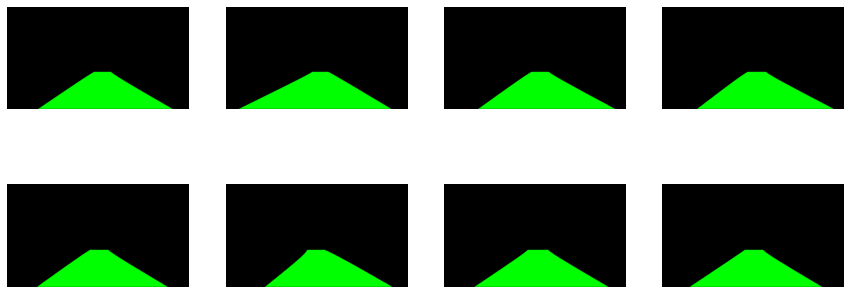

In [29]:
show_image(lanesOverlay,2,4)
# plt.savefig("Find_The_Lanes_&_Draw_The_Frames.png")

**Warp the detected lane boundaries back onto the original image.**

In [30]:
# Combine the result with the original image
imgLength = len(Undist_images)
resultLines = []
for index in range(0,imgLength) :
  img = cv2.addWeighted(Undist_images[index], 1, lanesOverlay[index], 0.3, 0)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB )
  resultLines.append(img)

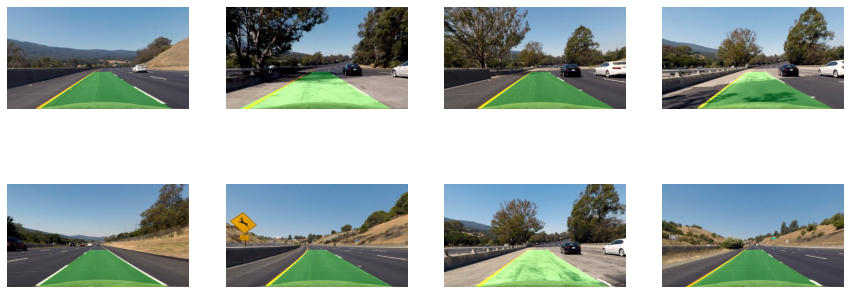

In [31]:
show_image(resultLines,2,4)
# plt.savefig("lane_detected.png")

**Determine the curvature of the lane**

In [32]:
# Calculate the radius of curvature in meters for both lane lines
curvatures_right = []
curvatures_left = []
callNext = False 

for img in Warped_imgs:
  if(not callNext ) :
    out_img,left_fit,right_fit,lcr,rcr = find_firstlane(img)
    callNext = True
  else :
    out_img,left_fit,right_fit,lcr,rcr = search_next_Lane(img,left_fit,right_fit)
  (lcurve,rcurve) = measure_curvature(lcr,rcr)
  curvature_left = lcurve/1000 
  curvature_right = rcurve/1000
  curvatures_left.append(curvature_left)
  curvatures_right.append(curvature_right)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

**Output visual display of the lane boundaries and numerical estimation of lane curvature.**

In [33]:
# Draw info
imgLength = len(resultLines)
for index in range(0,imgLength) :
  cv2.putText(resultLines[index],"Radius of Left Curvature:  "+ '{:6.2f} km'.format(curvatures_left[index]), (50, 50), cv2.FONT_HERSHEY_SIMPLEX,1.0,[0,0,255],2, cv2.LINE_AA)
  cv2.putText(resultLines[index],"Radius of right Curvature:  "+ '{:6.2f} km'.format(curvatures_right[index]), (50, 120), cv2.FONT_HERSHEY_SIMPLEX,1.0,[0,0,255],2, cv2.LINE_AA)


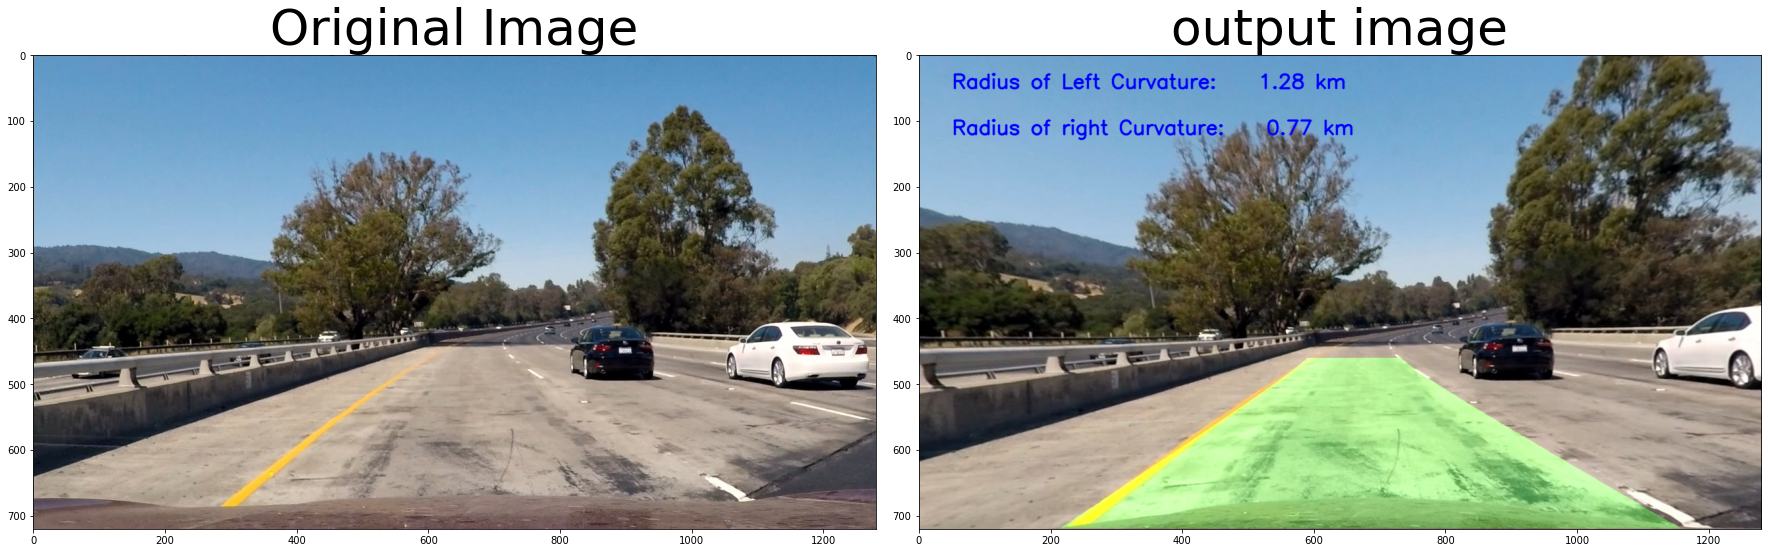

In [35]:
# the first warped image

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(Test_imgsToShow[6])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(resultLines[6])
ax2.set_title('output image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# plt.savefig("output.png")

# **Video pipeline**

In [ ]:
callNext = False

def calculateLanes(img):
    """
    Calculates the lane on image `img`.
    """
    Undist = cal_undistort(img, mtx, dist)

    imghls = hls_select(Undist, thresh=(90, 255))
    grad_binaryx = abs_sobel_thresh(Undist, orient='x', thresh_min=20, thresh_max=100)
    grad_binaryy = abs_sobel_thresh(Undist, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(Undist, sobel_kernel=3, mag_thresh=(30, 170))
    dir_binary = dir_threshold(Undist, sobel_kernel=15, thresh=(0.7, 1.3))

    Combining_Thresholds = Combining_Threshold(dir_binary,grad_binaryx,grad_binaryy,mag_binary,imghls)

    img,Minv = unwarp(Combining_Thresholds)


    global callNext

    if(callNext==False ) :
       out_img,lf,rf,lcr,rcr = find_firstlane(img)
       callNext = True

    if(callNext) :
       out_img,lf,rf,lcr,rcr = search_next_Lane(img,left_fit,right_fit)
       
    # Calculate curvature

    (lcurve,rcurve) = measure_curvature(lcr,rcr)
    curvature_left = lcurve/1000 
    curvature_right = rcurve/1000

    return (Undist,out_img,lf, rf, curvature_left, curvature_right,Minv)


def displayLanes(Undist,out_img, left_fit, right_fit,leftCurvature, rightCurvature, Minv):
    """
    Display the lanes information on the image.
    """
    laneDrowed = draw(out_img,left_fit,right_fit, Minv)
    img = cv2.addWeighted(Undist, 1, laneDrowed, 0.3, 0)

    # Draw info
    cv2.putText(img,"Radius of Left Curvature:  "+ '{:6.2f} km'.format(leftCurvature), (50, 50), cv2.FONT_HERSHEY_SIMPLEX,1.0,[0,0,255],2, cv2.LINE_AA)
    cv2.putText(img,"Radius of right Curvature:  "+ '{:6.2f} km'.format(rightCurvature), (50, 120), cv2.FONT_HERSHEY_SIMPLEX,1.0,[0,0,255],2, cv2.LINE_AA)

    return img

  


In [ ]:
# !pip install moviepy

In [ ]:
# !pip3 install imageio==2.4.1

In [ ]:
from moviepy.editor import VideoFileClip

def videoPipeline(inputVideo, outputVideo,subC=None):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute information and
    generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)


    def processImage(img) :

      Undist,out_img,left_fit, right_fit, curvature_left, curvature_right,Minv = calculateLanes(img)

      result = displayLanes(Undist,out_img,left_fit, right_fit, curvature_left, curvature_right,Minv)

      return result

    if(subC != None) :
        myclip = myclip.subclip(subC[0],subC[1])

    
    clip = myclip.fl_image(processImage) 
    clip.write_videofile(outputVideo, audio=False)


In [ ]:
videoPipeline('project_video.mp4', 'project_video_final.mp4',subC=None)

[MoviePy] >>>> Building video project_video_final.mp4
[MoviePy] Writing video project_video_final.mp4


100%|█████████▉| 1260/1261 [04:46<00:00,  4.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_final.mp4 

